In [1]:
import cv2
import numpy as np

## Setting up camera

In [2]:
# def nothing(x):
#     pass

# cv2.namedWindow("Window")
# cv2.createTrackbar("Param Name", "Window", 0, 10, nothing)

In [3]:
def try_camera(func):
    cap = cv2.VideoCapture(1)

    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Our operations on the frame come here
        try:
            gray = func(frame) # cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the resulting frame
            cv2.imshow('frame', gray)
        except:
            print("Nothing found...")
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
    
# try_camera(lambda x : x)

## Part 1: Extracting Hand from Feed

In [4]:
# ! {"pip install matplotlib"}

In [5]:
frame = np.load('open_palm.npy')

In [6]:
import matplotlib.pyplot as plt

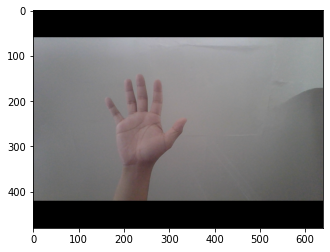

In [7]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [8]:
frame.shape

(480, 640, 3)

In [9]:
def get_skinmask(frame):
    lower_HSV = np.array([0, 70, 0], dtype = "uint8")  
    upper_HSV = np.array([25, 255, 255], dtype = "uint8")  

    convertedHSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)  
    skinMaskHSV = cv2.inRange(convertedHSV, lower_HSV, upper_HSV)  


    lower_YCrCb = np.array((0, 138, 67), dtype = "uint8")  
    upper_YCrCb = np.array((255, 173, 133), dtype = "uint8")  

    convertedYCrCb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)  
    skinMaskYCrCb = cv2.inRange(convertedYCrCb, lower_YCrCb, upper_YCrCb)  

    skinMask = cv2.add(skinMaskHSV,skinMaskYCrCb)  
    return skinMask

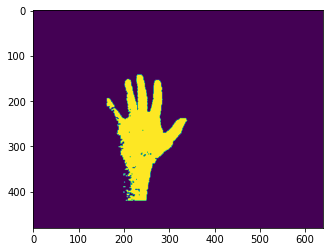

In [10]:
plt.imshow(get_skinmask(frame))

Testing Code

In [11]:
# try_camera(get_skinmask)

In [12]:
def morph_and_blur(frame, skinMask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))  
    skinMask = cv2.erode(skinMask, kernel, iterations = 1)  
    skinMask = cv2.dilate(skinMask, kernel, iterations = 1)  

    # blur the mask to help remove noise, then apply the  
    # mask to the frame  
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0) 
    skin = cv2.bitwise_and(frame, frame, mask = skinMask) 
    return skin

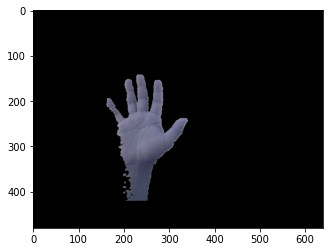

In [13]:
plt.imshow(morph_and_blur(frame, get_skinmask(frame)))

In [14]:
isolate = lambda x : morph_and_blur(x, get_skinmask(x))
# try_camera(isolate)

## Part 2: Connected Components for Gesture Recognition

In [15]:
ok_hand = np.load('ok.npy')

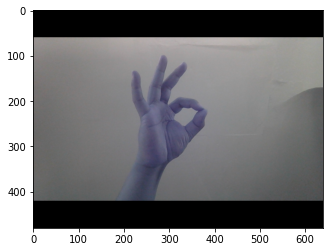

In [16]:
plt.imshow(ok_hand)

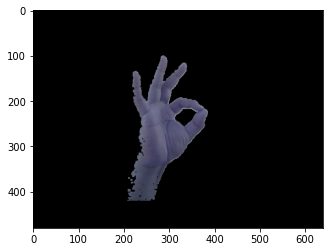

In [17]:
plt.imshow(isolate(ok_hand).astype(np.uint8))

In [18]:
def gray_thresh(frame):
    max_binary_value = 10
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)  
    ret, thresh = cv2.threshold(gray, 0, max_binary_value, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU )
    return thresh # thresh if ret else None

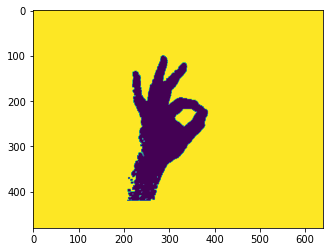

In [19]:
plt.imshow(gray_thresh(isolate(ok_hand)))

In [20]:
def arr2img(arr):
    arr = np.uint8(arr / np.max(arr) * 255)
    return cv2.merge([arr, arr, arr])

In [21]:
# try_camera(lambda x : arr2img(gray_thresh(isolate(x))))

In [22]:
def get_connect(img):
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
    markers = np.array(markers, dtype=np.uint8)  
    return arr2img(markers)

In [23]:
marks = get_connect(gray_thresh(isolate(ok_hand)))

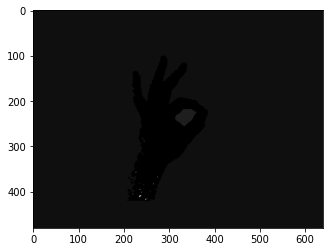

In [24]:
plt.imshow(marks)

Test out code so far...

In [25]:
render_comps = lambda x : get_connect(gray_thresh(isolate(x)))
# try_camera(render_comps)

In [26]:
def get_connect2(img):
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
    markers = np.array(markers, dtype=np.uint8)  
    labeled_img = arr2img(markers)
    
    # sort by area of ROI
    statsSortedByArea = stats[np.argsort(stats[:, 4])]  
    roi = statsSortedByArea[-3][0:4]  
    x, y, w, h = roi  
    subImg = labeled_img[y:y+h, x:x+w]
    subImg = cv2.cvtColor(subImg, cv2.COLOR_BGR2GRAY)
    
    _, contours, _ = cv2.findContours(subImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
    maxCntLength = 0  
    for i in range(0,len(contours)):  
        cntLength = len(contours[i])  
        if(cntLength>maxCntLength):  
            cnt = contours[i]  
            maxCntLength = cntLength  
    if(maxCntLength>=5):  
        ellipseParam = cv2.fitEllipse(cnt)
        (x,y), (MA, ma), angle = ellipseParam
        print(f"(x={x}, y={y}), (MA={MA}, ma={ma}), Angle={angle}")
        subImg = cv2.cvtColor(subImg, cv2.COLOR_GRAY2RGB);  
        subImg = cv2.ellipse(subImg,ellipseParam,(0,255,0),2)  

    subImg = cv2.resize(subImg, (0,0), fx=3, fy=3)
    return subImg

In [42]:
render_comps2 = lambda x : get_connect2(gray_thresh(isolate(x)))
try_camera(render_comps2)

Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
(x=16.671804428100586, y=12.941437721252441), (MA=13.836152076721191, ma=36.7921257019043), Angle=55.335655212402344
(x=10.603551864624023, y=17.781883239746094), (MA=16.6503849029541, ma=31.080307006835938), Angle=19.443666458129883
(x=10.420220375061

(x=12.32559871673584, y=17.67202377319336), (MA=9.891861915588379, ma=38.1463508605957), Angle=36.35597610473633
(x=11.83907699584961, y=18.408145904541016), (MA=9.62336540222168, ma=39.23860549926758), Angle=34.98986053466797
(x=15.271750450134277, y=21.616708755493164), (MA=9.846884727478027, ma=46.60538864135742), Angle=37.981868743896484
(x=15.19363784790039, y=21.397531509399414), (MA=9.276274681091309, ma=46.81688690185547), Angle=37.45811462402344
(x=15.016168594360352, y=22.31633758544922), (MA=9.95545482635498, ma=46.0943603515625), Angle=37.6014289855957
(x=16.7383975982666, y=22.720462799072266), (MA=10.6138334274292, ma=51.32059860229492), Angle=37.07498550415039
(x=15.644482612609863, y=23.9284610748291), (MA=10.583574295043945, ma=52.06679153442383), Angle=38.45734786987305
(x=17.029705047607422, y=24.470836639404297), (MA=11.039708137512207, ma=53.42000961303711), Angle=37.64125061035156
(x=25.224241256713867, y=32.946929931640625), (MA=20.27155876159668, ma=68.290084838

(x=30.748275756835938, y=29.947628021240234), (MA=54.50423812866211, ma=58.5240592956543), Angle=89.21363830566406
(x=29.56067657470703, y=30.91631317138672), (MA=53.27639389038086, ma=60.58272171020508), Angle=108.69009399414062
(x=29.945064544677734, y=32.115257263183594), (MA=53.15715026855469, ma=59.51679992675781), Angle=96.62125396728516
(x=30.609180450439453, y=31.880126953125), (MA=53.802001953125, ma=61.08546829223633), Angle=98.21588134765625
(x=27.010374069213867, y=30.348241806030273), (MA=52.22520446777344, ma=56.51984405517578), Angle=167.068115234375
(x=28.194013595581055, y=20.74476432800293), (MA=36.192962646484375, ma=54.99192810058594), Angle=57.98079299926758
(x=26.933645248413086, y=19.558319091796875), (MA=34.850643157958984, ma=54.77421951293945), Angle=53.39385223388672
(x=26.90706443786621, y=20.396949768066406), (MA=34.925392150878906, ma=55.27191162109375), Angle=51.84555435180664
(x=27.6114501953125, y=21.87053108215332), (MA=36.403839111328125, ma=56.006645

(x=11.205391883850098, y=14.755208015441895), (MA=7.824446201324463, ma=39.09525680541992), Angle=51.482730865478516
(x=22.94353485107422, y=50.605865478515625), (MA=34.40618896484375, ma=86.47216033935547), Angle=10.741308212280273
(x=8.734722137451172, y=17.45929527282715), (MA=10.118752479553223, ma=29.653671264648438), Angle=20.080217361450195
(x=23.238344192504883, y=48.7289924621582), (MA=36.095794677734375, ma=84.66891479492188), Angle=13.068220138549805
(x=27.05975914001465, y=53.46908950805664), (MA=39.78245162963867, ma=90.18832397460938), Angle=12.376806259155273
(x=4.821981906890869, y=6.585109710693359), (MA=5.178946495056152, ma=15.019074440002441), Angle=34.71635437011719
(x=7.103940010070801, y=8.346963882446289), (MA=7.48932409286499, ma=19.33122444152832), Angle=35.24253845214844
(x=6.714657306671143, y=8.35648250579834), (MA=5.9452667236328125, ma=20.569551467895508), Angle=36.13985824584961
(x=6.932038307189941, y=8.790901184082031), (MA=7.305098533630371, ma=19.865

(x=18.93355941772461, y=32.359588623046875), (MA=31.52358055114746, ma=59.04714584350586), Angle=13.322233200073242
(x=35.324100494384766, y=28.083730697631836), (MA=47.38558578491211, ma=69.98847961425781), Angle=72.60714721679688
(x=16.353092193603516, y=30.144319534301758), (MA=26.873807907104492, ma=53.2200927734375), Angle=0.3848837912082672
(x=55.68645477294922, y=50.103065490722656), (MA=67.38536071777344, ma=107.05589294433594), Angle=58.748741149902344
(x=19.981050491333008, y=44.47041320800781), (MA=29.412425994873047, ma=75.49388885498047), Angle=10.019916534423828
(x=18.908769607543945, y=48.059391021728516), (MA=31.03655433654785, ma=75.14733123779297), Angle=9.309477806091309
(x=18.193147659301758, y=48.20843505859375), (MA=27.96764373779297, ma=79.7627182006836), Angle=13.136231422424316
(x=42.70082473754883, y=26.822568893432617), (MA=30.9621639251709, ma=98.55833435058594), Angle=62.02324295043945
(x=41.14717483520508, y=28.411460876464844), (MA=31.72373390197754, ma=9

(x=29.823701858520508, y=21.070653915405273), (MA=35.561431884765625, ma=59.57989501953125), Angle=68.08425903320312
(x=30.35624122619629, y=21.46438217163086), (MA=37.237281799316406, ma=58.480445861816406), Angle=71.5163345336914
(x=29.36028289794922, y=21.66020393371582), (MA=36.15977478027344, ma=59.594573974609375), Angle=69.17046356201172
(x=33.83602523803711, y=22.104272842407227), (MA=37.176124572753906, ma=67.99159240722656), Angle=80.11918640136719
(x=28.916275024414062, y=21.57540512084961), (MA=35.43644332885742, ma=58.96965789794922), Angle=66.9547119140625
(x=30.379806518554688, y=21.08617401123047), (MA=35.872501373291016, ma=59.833988189697266), Angle=67.99867248535156
(x=30.239112854003906, y=21.256549835205078), (MA=35.997947692871094, ma=60.18867492675781), Angle=68.70260620117188
(x=34.07143783569336, y=21.787153244018555), (MA=37.79878234863281, ma=66.85646057128906), Angle=78.5391616821289
(x=31.249195098876953, y=21.660358428955078), (MA=35.95562744140625, ma=61.

(x=15.605751991271973, y=62.518516540527344), (MA=23.92392921447754, ma=118.33619689941406), Angle=170.9303741455078
(x=14.277777671813965, y=44.906620025634766), (MA=21.589445114135742, ma=97.38516235351562), Angle=11.456859588623047
(x=11.840279579162598, y=35.478816986083984), (MA=22.78618812561035, ma=63.93728256225586), Angle=5.556027412414551
(x=9.951315879821777, y=29.68656349182129), (MA=21.298938751220703, ma=54.54242706298828), Angle=8.237689971923828
(x=10.484506607055664, y=29.789451599121094), (MA=19.563472747802734, ma=54.4158935546875), Angle=12.408434867858887
(x=10.528096199035645, y=29.966182708740234), (MA=18.80250358581543, ma=50.385398864746094), Angle=11.205354690551758
(x=8.105500221252441, y=22.910205841064453), (MA=11.028058052062988, ma=44.995365142822266), Angle=11.886144638061523
(x=2.2269484996795654, y=7.268041133880615), (MA=4.387384414672852, ma=16.208202362060547), Angle=5.5767951011657715
(x=2.6617045402526855, y=3.3441057205200195), (MA=3.560340881347

(x=1.3666666746139526, y=1.0), (MA=2.162310838699341, ma=3.790308952331543), Angle=135.9713897705078
(x=0.9090908765792847, y=1.8181817531585693), (MA=1.8457931280136108, ma=2.1948623657226562), Angle=164.51812744140625
(x=2.090909004211426, y=1.1818182468414307), (MA=2.290864944458008, ma=4.307387828826904), Angle=103.28252410888672
(x=3.3529412746429443, y=3.617647171020508), (MA=1.027567744255066, ma=1.3253631591796875), Angle=0.0
(x=1.83648681640625, y=1.475374460220337), (MA=3.1143579483032227, ma=4.092822551727295), Angle=86.1670150756836
(x=1.1764706373214722, y=0.7058823108673096), (MA=1.3513513803482056, ma=1.3513513803482056), Angle=0.0
(x=0.5, y=1.5), (MA=1.3179659843444824, ma=1.752246379852295), Angle=61.845035552978516
(x=1.3043477535247803, y=1.2173912525177002), (MA=2.7944130897521973, ma=3.7374045848846436), Angle=112.5
(x=1.4155200719833374, y=1.7418770790100098), (MA=2.824702262878418, ma=3.830590009689331), Angle=51.3589973449707
(x=1.4662399291992188, y=1.766291737

(x=9.77993106842041, y=7.175057411193848), (MA=12.917590141296387, ma=17.32464599609375), Angle=114.85084533691406
(x=9.076141357421875, y=6.072687149047852), (MA=11.756158828735352, ma=17.89701271057129), Angle=102.82982635498047
(x=9.82780647277832, y=6.40754508972168), (MA=13.046689987182617, ma=18.61660385131836), Angle=106.25990295410156
(x=9.913634300231934, y=6.02628755569458), (MA=12.402270317077637, ma=19.77998161315918), Angle=101.02910614013672
(x=9.557746887207031, y=6.503522872924805), (MA=13.276198387145996, ma=18.890295028686523), Angle=97.78225708007812
(x=14.209482192993164, y=27.752107620239258), (MA=23.847780227661133, ma=50.11075973510742), Angle=14.91037368774414
(x=9.225358963012695, y=6.237558364868164), (MA=12.427017211914062, ma=18.724864959716797), Angle=107.22819519042969
(x=9.66537094116211, y=6.768528938293457), (MA=13.106842994689941, ma=18.350994110107422), Angle=101.19073486328125
(x=9.238049507141113, y=7.291058540344238), (MA=13.818955421447754, ma=18.

(x=50.481937408447266, y=34.492462158203125), (MA=57.561893463134766, ma=86.5810546875), Angle=91.74698638916016
(x=48.575984954833984, y=37.9798469543457), (MA=63.48508834838867, ma=82.98300170898438), Angle=82.96337127685547
(x=46.98715591430664, y=36.099056243896484), (MA=58.04490280151367, ma=80.19672393798828), Angle=90.70378112792969
(x=48.73491287231445, y=36.74829864501953), (MA=57.784324645996094, ma=85.4215087890625), Angle=84.87684631347656
(x=50.668006896972656, y=46.38274383544922), (MA=69.53743743896484, ma=104.76470947265625), Angle=52.06147384643555
(x=28.594789505004883, y=22.372316360473633), (MA=38.22344207763672, ma=58.4921989440918), Angle=71.2652587890625
(x=43.95418930053711, y=42.892845153808594), (MA=55.668148040771484, ma=101.75300598144531), Angle=47.63896179199219
(x=46.693294525146484, y=47.4880485534668), (MA=66.11343383789062, ma=101.80209350585938), Angle=47.812583923339844
(x=44.30739212036133, y=36.10001754760742), (MA=57.65359878540039, ma=75.01133728

(x=29.702125549316406, y=22.41278076171875), (MA=39.15199279785156, ma=58.91474914550781), Angle=58.57133483886719
(x=29.423166275024414, y=21.816848754882812), (MA=39.48843765258789, ma=58.435306549072266), Angle=59.853172302246094
(x=31.170305252075195, y=22.269744873046875), (MA=39.56413269042969, ma=62.57554626464844), Angle=62.06017303466797
(x=29.571744918823242, y=22.60526466369629), (MA=39.96991729736328, ma=58.74848937988281), Angle=59.0494384765625
(x=30.084636688232422, y=22.80849838256836), (MA=40.31818389892578, ma=59.825618743896484), Angle=61.41141128540039
(x=30.281362533569336, y=23.244338989257812), (MA=41.090484619140625, ma=58.10808181762695), Angle=63.10926055908203
(x=34.77973175048828, y=24.319908142089844), (MA=42.90386962890625, ma=70.55435180664062), Angle=79.8836898803711
(x=29.804508209228516, y=23.0866641998291), (MA=40.52280044555664, ma=58.78570556640625), Angle=59.66984939575195
(x=29.407564163208008, y=22.9351749420166), (MA=40.95890426635742, ma=58.482

(x=31.466583251953125, y=24.1068172454834), (MA=42.27747344970703, ma=60.27898025512695), Angle=67.48310089111328
(x=30.395849227905273, y=23.863969802856445), (MA=41.929664611816406, ma=60.16929244995117), Angle=60.55406188964844
(x=30.043521881103516, y=24.26861572265625), (MA=41.85419845581055, ma=59.615962982177734), Angle=63.35961151123047
(x=31.01930046081543, y=24.194669723510742), (MA=42.0883674621582, ma=60.272247314453125), Angle=62.65227508544922
(x=31.71567153930664, y=24.805744171142578), (MA=42.75373077392578, ma=60.13744354248047), Angle=67.36894989013672
(x=31.627321243286133, y=24.318418502807617), (MA=42.19926071166992, ma=60.20082092285156), Angle=67.60245513916016
(x=31.392948150634766, y=24.071928024291992), (MA=41.04440689086914, ma=60.943702697753906), Angle=65.50557708740234
(x=30.700517654418945, y=25.306909561157227), (MA=43.31209945678711, ma=59.32681655883789), Angle=65.10179901123047
(x=30.873031616210938, y=24.055612564086914), (MA=42.24563217163086, ma=60

(x=31.952983856201172, y=24.236286163330078), (MA=41.33464431762695, ma=63.79816436767578), Angle=63.85454559326172
(x=30.702865600585938, y=24.129127502441406), (MA=41.27781295776367, ma=64.06261444091797), Angle=60.71250534057617
(x=36.41238784790039, y=25.357717514038086), (MA=44.922210693359375, ma=73.03489685058594), Angle=77.14554595947266
(x=32.200035095214844, y=24.52797508239746), (MA=42.68705749511719, ma=63.32456588745117), Angle=64.65667724609375
(x=31.5189208984375, y=24.827281951904297), (MA=41.51408386230469, ma=64.31330871582031), Angle=61.71189880371094
(x=32.566009521484375, y=24.522159576416016), (MA=41.218055725097656, ma=63.9890251159668), Angle=61.29039001464844
(x=35.40385055541992, y=25.866256713867188), (MA=44.25857162475586, ma=71.43599700927734), Angle=65.557861328125
(x=9.989608764648438, y=25.080835342407227), (MA=15.907257080078125, ma=46.18085479736328), Angle=170.04776000976562
(x=9.37228012084961, y=27.220550537109375), (MA=15.545427322387695, ma=44.350

(x=32.79441452026367, y=25.966697692871094), (MA=43.00008773803711, ma=66.29170227050781), Angle=63.85258865356445
(x=33.04351806640625, y=27.20429229736328), (MA=46.351898193359375, ma=65.38184356689453), Angle=68.06053161621094
(x=32.98471450805664, y=26.292850494384766), (MA=45.644351959228516, ma=66.06441497802734), Angle=73.33968353271484
(x=32.5313720703125, y=25.24198341369629), (MA=45.546417236328125, ma=64.64518737792969), Angle=77.38544464111328
(x=55.28940963745117, y=45.28093338012695), (MA=72.95755767822266, ma=107.27490997314453), Angle=64.35328674316406
(x=32.379112243652344, y=24.80843162536621), (MA=43.25128936767578, ma=65.92884063720703), Angle=76.66714477539062
(x=56.890342712402344, y=50.02203369140625), (MA=84.45944213867188, ma=108.36641693115234), Angle=58.437068939208984
(x=54.6564826965332, y=46.263614654541016), (MA=72.3685302734375, ma=106.30760955810547), Angle=64.1048355102539
(x=55.34984588623047, y=45.29869842529297), (MA=72.40200805664062, ma=106.145103

(x=11.300637245178223, y=27.592008590698242), (MA=17.056602478027344, ma=54.36962890625), Angle=167.20120239257812
(x=14.184300422668457, y=35.0189094543457), (MA=24.393213272094727, ma=57.94637680053711), Angle=178.2759552001953
(x=11.316729545593262, y=21.394153594970703), (MA=17.876514434814453, ma=44.82334899902344), Angle=169.6615447998047
(x=11.777217864990234, y=39.14482879638672), (MA=19.900531768798828, ma=66.16482543945312), Angle=0.9071917533874512
(x=12.708207130432129, y=8.054801940917969), (MA=9.993080139160156, ma=27.39977264404297), Angle=56.873878479003906
(x=12.075918197631836, y=31.740921020507812), (MA=18.253238677978516, ma=55.16621780395508), Angle=174.92481994628906
(x=10.451799392700195, y=24.106313705444336), (MA=16.719402313232422, ma=50.34714889526367), Angle=172.47328186035156
(x=11.738576889038086, y=25.481773376464844), (MA=17.920583724975586, ma=45.530704498291016), Angle=166.36801147460938
(x=33.422149658203125, y=26.16477394104004), (MA=44.1780357360839

(x=19.486833572387695, y=44.63557052612305), (MA=30.422382354736328, ma=76.63411712646484), Angle=5.208983898162842
(x=14.67233657836914, y=46.071109771728516), (MA=22.627470016479492, ma=71.203369140625), Angle=4.448525428771973
(x=13.027010917663574, y=26.01113510131836), (MA=19.99842643737793, ma=52.46965789794922), Angle=171.49525451660156
(x=11.426484107971191, y=24.068744659423828), (MA=18.02125358581543, ma=47.723899841308594), Angle=170.51634216308594
(x=12.024996757507324, y=36.142181396484375), (MA=20.022212982177734, ma=64.03428649902344), Angle=179.72030639648438
(x=13.599397659301758, y=11.425822257995605), (MA=10.598254203796387, ma=35.6884880065918), Angle=54.75625228881836
(x=14.593503952026367, y=11.608745574951172), (MA=12.175200462341309, ma=34.94319152832031), Angle=52.233856201171875
(x=14.485867500305176, y=11.007576942443848), (MA=12.156582832336426, ma=35.08185958862305), Angle=51.736289978027344
(x=15.601802825927734, y=10.400856971740723), (MA=11.2355709075927

(x=13.716322898864746, y=21.43364906311035), (MA=20.756208419799805, ma=36.53397750854492), Angle=163.0493621826172
(x=12.902470588684082, y=28.725236892700195), (MA=18.226886749267578, ma=56.82660675048828), Angle=2.546173572540283
(x=12.120027542114258, y=25.50092124938965), (MA=20.319791793823242, ma=44.80818557739258), Angle=6.698371410369873
(x=13.627593994140625, y=19.546432495117188), (MA=21.124271392822266, ma=38.628360748291016), Angle=164.7738494873047
(x=10.007491111755371, y=23.102426528930664), (MA=17.901344299316406, ma=46.74207305908203), Angle=174.29006958007812
(x=13.446998596191406, y=21.837419509887695), (MA=18.55730628967285, ma=42.97637176513672), Angle=164.48008728027344
(x=10.720905303955078, y=19.978065490722656), (MA=18.166486740112305, ma=38.247554779052734), Angle=179.39430236816406
(x=10.472970008850098, y=21.88892364501953), (MA=17.36866569519043, ma=42.103485107421875), Angle=169.79295349121094
(x=14.153838157653809, y=23.131675720214844), (MA=21.940294265

(x=31.011489868164062, y=26.0430965423584), (MA=44.0388298034668, ma=63.472007751464844), Angle=55.52774429321289
(x=31.986648559570312, y=26.29603385925293), (MA=44.661651611328125, ma=63.42152786254883), Angle=58.73436737060547
(x=32.133060455322266, y=27.225746154785156), (MA=45.72289276123047, ma=62.920989990234375), Angle=58.79042053222656
(x=32.28795623779297, y=26.849872589111328), (MA=44.76700210571289, ma=63.11238098144531), Angle=58.20066452026367
(x=32.299095153808594, y=25.914142608642578), (MA=43.48091125488281, ma=64.13984680175781), Angle=58.26134490966797
(x=32.2439079284668, y=26.443702697753906), (MA=43.76966094970703, ma=63.821990966796875), Angle=59.658668518066406
(x=32.42367935180664, y=26.698144912719727), (MA=44.25566864013672, ma=63.69679260253906), Angle=58.78927230834961
(x=32.12721633911133, y=26.961959838867188), (MA=44.67190933227539, ma=63.047298431396484), Angle=57.2093505859375
(x=31.793691635131836, y=26.25318717956543), (MA=44.179229736328125, ma=63.2

(x=23.494850158691406, y=25.279245376586914), (MA=41.59364700317383, ma=64.58106231689453), Angle=41.870628356933594
(x=24.11351203918457, y=24.978004455566406), (MA=41.541446685791016, ma=63.9029541015625), Angle=43.44883728027344
(x=22.69632911682129, y=24.559919357299805), (MA=38.98256301879883, ma=65.93689727783203), Angle=43.731319427490234
(x=22.431522369384766, y=24.745891571044922), (MA=38.965660095214844, ma=67.17534637451172), Angle=43.06816864013672
(x=23.7427921295166, y=24.723587036132812), (MA=41.33930587768555, ma=63.13496780395508), Angle=42.31525802612305
(x=24.071550369262695, y=25.493650436401367), (MA=41.359619140625, ma=64.23086547851562), Angle=42.9440803527832
(x=23.37416648864746, y=25.291336059570312), (MA=41.19853210449219, ma=65.23040008544922), Angle=43.400428771972656
(x=23.282617568969727, y=26.002222061157227), (MA=40.72905349731445, ma=66.27928924560547), Angle=41.77052688598633
(x=23.30063247680664, y=25.232126235961914), (MA=40.85778045654297, ma=65.68

## Part 3: Tracking 2D Finger Positions

In [28]:
def get_gray_thresh(x):
    img = arr2img(1 * (gray_thresh(isolate(x)) == 0))
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

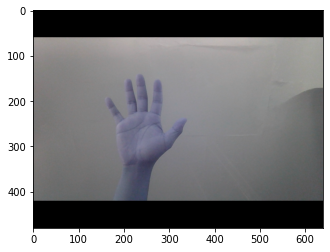

In [29]:
plt.imshow(np.load('open_palm.npy'))

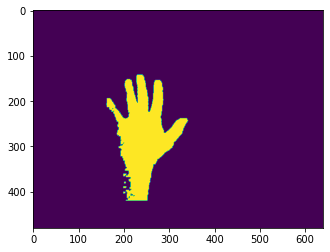

In [30]:
plt.imshow(get_gray_thresh(np.load('open_palm.npy')))

In [31]:
def get_hull(thresholdedHandImage):
    _, contours, _ = cv2.findContours(thresholdedHandImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    thresholdedHandImage = cv2.cvtColor(thresholdedHandImage, cv2.COLOR_GRAY2BGR)
    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    fingerCount = 0
    fingerPts = []
    if len(contours)>1:  
        largestContour = contours[0]  
        hull = cv2.convexHull(largestContour, returnPoints = False)     
        for cnt in contours[:1]:  
            defects = cv2.convexityDefects(cnt,hull)  
            if(not isinstance(defects,type(None))):  
                for i in range(defects.shape[0]):  
                    s,e,f,d = defects[i,0]  
                    start = tuple(cnt[s][0])  
                    end = tuple(cnt[e][0])  
                    far = tuple(cnt[f][0])
                    
                    # finger detection
                    c_squared = (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2  
                    a_squared = (far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2  
                    b_squared = (end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2  
                    angle = np.arccos((a_squared + b_squared  - c_squared ) / (2 * np.sqrt(a_squared * b_squared ))) 
                    
                    if angle <= np.pi / 3:
                        fingerCount += 1 
                        cv2.circle(thresholdedHandImage,far,5,[0,0,255],-1)
                        fingerPts.append(far)
                    cv2.line(thresholdedHandImage,start,end,[0,255,0],2)
                
        print(fingerCount)
        
    return thresholdedHandImage

In [32]:
get_conv_img = lambda x : get_hull(get_gray_thresh(x))

3


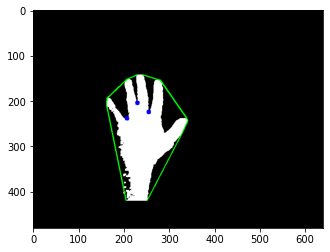

In [33]:
plt.imshow(get_conv_img(np.load('open_palm.npy')))

In [34]:
# try_camera(get_conv_img)

## Part 4: Control Mouse and Keyboard

Simple Gestures:
1. Finger Count:
    - 2 = open file
    - 3 = save file
2. OK Sign:
    - Click

Complex Gestures:

Harder:
3. Open - Close
    - Zoom Out
4. Close - Open
    - Zoom In
    
Implemented:
5. Closed + Center Circle Radius > 120
    - Ctrl + Z
    
Thinking:
6. Pinch axis
    - 

In [91]:
from scipy.stats import mode

In [94]:
def paint_conv_on_frame(thresholdedHandImage, regular_img, centers, open_closes, finger_counts):
    _, contours, _ = cv2.findContours(thresholdedHandImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText  = (10,30)
    bottomLeftCornerOfText2 = (10,60)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    
    thresholdedHandImage = regular_img
    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    fingerCount = 0
    fingerPts = []
    startEndPts = []
    if len(contours)>1:  
        largestContour = contours[0]  
        hull = cv2.convexHull(largestContour, returnPoints = False)     
        for cnt in contours[:1]:  
            defects = cv2.convexityDefects(cnt,hull)  
            if(not isinstance(defects,type(None))):  
                for i in range(defects.shape[0]):  
                    s,e,f,d = defects[i,0]  
                    start = tuple(cnt[s][0])  
                    end = tuple(cnt[e][0])  
                    far = tuple(cnt[f][0])
                    
                    # finger detection
                    c_squared = (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2  
                    a_squared = (far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2  
                    b_squared = (end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2  
                    angle = np.arccos((a_squared + b_squared  - c_squared ) / (2 * np.sqrt(a_squared * b_squared ))) 
                    
                    if angle <= np.pi / 3:
                        fingerCount += 1 
                        cv2.circle(thresholdedHandImage,far,5,[0,0,255],-1)
                        fingerPts.append([far[i] for i in range(len(far))])
                    
                    cv2.line(thresholdedHandImage,start,end,[0,255,0],2)
                    # cv2.circle(thresholdedHandImage,start,5,[i * 20,0,255],-1)
                    # cv2.circle(thresholdedHandImage,end,5,[i * 20 + 100,0,255],-1)
                    startEndPts.append([start[i] for i in range(len(start))])
                    # startEndPts.append([end[i] for i in range(len(end))])
                    
                    
        # Hand Tracking
        if len(startEndPts) > 5:
            M = cv2.moments(largestContour)  
            cX = 0 + 1 * int(M["m10"] / M["m00"])  
            cY = 0 + int(0.9 * M["m01"] / M["m00"])
            centers.append(np.array([cX, cY]))
            centers_mat = np.vstack(centers)
            center = np.mean(centers_mat, axis=0).astype(np.int)

            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText = (10,30)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2
            cv2.circle(thresholdedHandImage, (center[0], center[1]), 5, [0,255,255], -1)
        
        # Draw Circle from Moment Center
        if len(startEndPts) > 5:
            pts = np.array(startEndPts)
            min_pts = np.array([cX, np.amin(pts, axis=0)[1]])
            dist = np.linalg.norm(min_pts - center, 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), 60, [0,255,255], 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), 120, [0,255,255], 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), int(dist), [0,255,0], 2)
        
        # Open Palm Detection
        if len(fingerPts) > 0 and len(startEndPts) > 5:
            pts = np.array(fingerPts)
            mean_pts = np.mean(pts, axis=0)
            min_pts = np.amin(pts, axis=0)
            dist = np.linalg.norm(min_pts - center, 2)
            # thresholdedHandImage = cv2.circle(
            #     thresholdedHandImage, (center[0], center[1]), int(dist), [0,255,0], 2)

            # print(tuple(np.ceil(mean_pts).astype(int).tolist()))
            open_closes.append(1)
            finger_counts.append(len(fingerPts))
            mean_finger_count = int(np.mean(finger_counts))
            cv2.putText(thresholdedHandImage, f"Num Fingers: {mean_finger_count}", 
                        bottomLeftCornerOfText2, 
                        font, fontScale, fontColor, lineType)
        elif len(startEndPts) > 5:
            open_closes.append(0)
        else:
            open_closes.append(-1)
    else:
        open_closes.append(-1)
        
    if np.mean(open_closes) >= 0.33:
        cv2.putText(thresholdedHandImage, "Open", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    elif np.mean(open_closes) < 0.33 and np.mean(open_closes) >= -0.33:
        cv2.putText(thresholdedHandImage, "Closed", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    else:
        cv2.putText(thresholdedHandImage, "No Hand Detected", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
            
    return thresholdedHandImage, centers, open_closes

def draw_center_of_ellipse(img, pinches):
    img = gray_thresh(isolate(img))
    try:
        ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
        markers = np.array(markers, dtype=np.uint8)  
        labeled_img = arr2img(markers)

        # sort by area of ROI
        statsSortedByArea = stats[np.argsort(stats[:, 4])]  
        roi = statsSortedByArea[-3][0:4]  
        x, y, w, h = roi  
        subImg = labeled_img[y:y+h, x:x+w]
        subImg = cv2.cvtColor(subImg, cv2.COLOR_BGR2GRAY)

        _, contours, _ = cv2.findContours(subImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
        maxCntLength = 0  
        for i in range(0,len(contours)):  
            cntLength = len(contours[i])  
            if(cntLength>maxCntLength):  
                cnt = contours[i]  
                maxCntLength = cntLength  
        if(maxCntLength>=5):  
            ellipseParam = cv2.fitEllipse(cnt)
            (x_sub, y_sub), (MA, ma), angle = ellipseParam
            # print(w * h)
            pinches.append((w * h > 1300) * 1)
            return np.mean(pinches) > 0.7
        pinches.append(0)
        return False
    except:
        pinches.append(0)
        return False

In [96]:
cap = cv2.VideoCapture(1)
centers_arr = []
open_closes_arr = [-1]
finger_counts = []
pinches = []

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    # try:
    gray = get_gray_thresh(frame)
    disp, centers_arr, open_closes_arr = paint_conv_on_frame(
        gray, frame, centers_arr, open_closes_arr, finger_counts
    )
    
    ellipse_found = draw_center_of_ellipse(frame, pinches)
    if ellipse_found:
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText  = (10,90)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        cv2.putText(disp, "Pinch", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    
    if len(centers_arr) > 20:
        centers_arr = centers_arr[1:]
    if len(open_closes_arr) > 15:
        open_closes_arr = open_closes_arr[1:]
    if len(finger_counts) > 15:
        finger_counts = finger_counts[1:]
    if len(pinches) > 15:
        pinches = pinches[1:]
        
    # Display the resulting frame
    cv2.imshow('frame', disp)
    # except:
    #     print("Nothing found...")
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in int_scalars
c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in arccos
